# Deep neural network model on synthesized time series

* Use linear regression and deep neural network to forecast a synthesized time siries
* Windowed time siries for training.
* Automatic tuning of learning rate with callbacks.

## Create time series with trend + seasonality + noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.sin(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

* Synthesized time sires with trend, seasonality, and noise

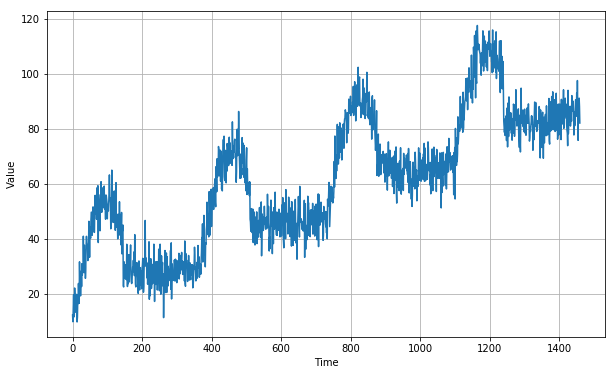

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series with trend and seasonality
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

* Split data to train and validation sets

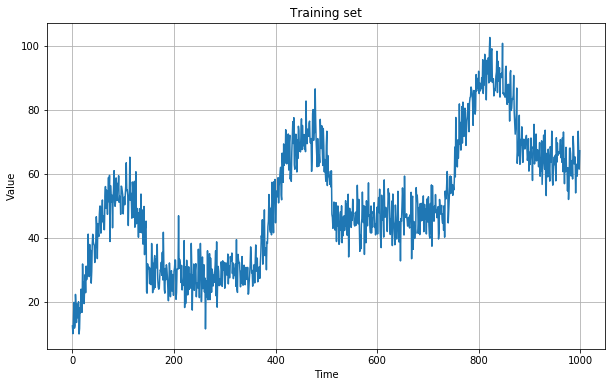

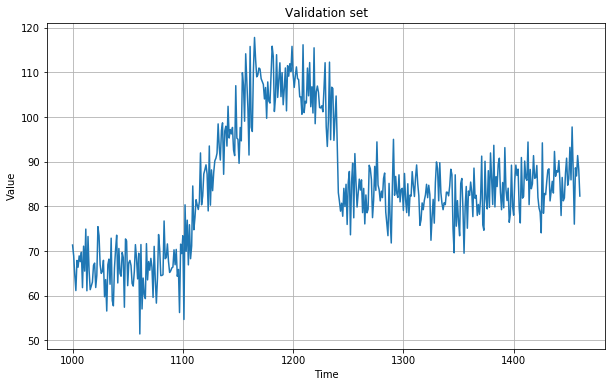

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("Training set")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("Validation set")
plt.show()

## Windowed time series

* Time windows generator (with tf.data.Dataset) for creating input datasets for training neural network.

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Create tensorflow dataset from time serie array
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Create windowed (nested) dataset
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flattening out the windowed dataset with a given window size
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffling the dataset & separating dataset into inputs and labels
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # Batch the input-label dataset with a given batch size
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Linear regression

* Here, we use linear regression with single-neuron single-layer neural network as a benchmark.
* The regression model is built with single-neuron single-layer neural network using keras.

In [5]:
# Create input dataset with training dataset
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model1 = tf.keras.models.Sequential([l0])
# Use stochastic gradient method for optimizer
model1.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Training
history1 = model1.fit(dataset,epochs=200,verbose=2)
print("Layer weights {}".format(l0.get_weights()))

Epoch 1/200
31/31 - 0s - loss: 963.3601
Epoch 2/200
31/31 - 0s - loss: 112.9236
Epoch 3/200
31/31 - 0s - loss: 98.9578
Epoch 4/200
31/31 - 0s - loss: 90.9483
Epoch 5/200
31/31 - 0s - loss: 87.8269
Epoch 6/200
31/31 - 0s - loss: 85.6113
Epoch 7/200
31/31 - 0s - loss: 83.3885
Epoch 8/200
31/31 - 0s - loss: 81.2726
Epoch 9/200
31/31 - 0s - loss: 79.2789
Epoch 10/200
31/31 - 0s - loss: 77.3925
Epoch 11/200
31/31 - 0s - loss: 75.6041
Epoch 12/200
31/31 - 0s - loss: 73.9064
Epoch 13/200
31/31 - 1s - loss: 72.2926
Epoch 14/200
31/31 - 1s - loss: 70.7565
Epoch 15/200
31/31 - 0s - loss: 69.2925
Epoch 16/200
31/31 - 0s - loss: 67.8957
Epoch 17/200
31/31 - 0s - loss: 66.5616
Epoch 18/200
31/31 - 0s - loss: 65.2860
Epoch 19/200
31/31 - 0s - loss: 64.0652
Epoch 20/200
31/31 - 0s - loss: 62.8959
Epoch 21/200
31/31 - 0s - loss: 61.7748
Epoch 22/200
31/31 - 0s - loss: 60.6993
Epoch 23/200
31/31 - 0s - loss: 59.6666
Epoch 24/200
31/31 - 0s - loss: 58.6745
Epoch 25/200
31/31 - 0s - loss: 57.7207
Epoch 2

* Plotting the training history

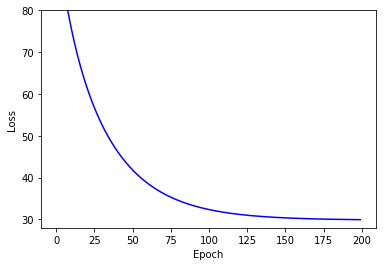

In [9]:
loss1 = history1.history['loss']
epochs1 = range(len(loss1))
plt.plot(epochs1, loss1, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([28,80])
plt.show()

* Plotting the prediction

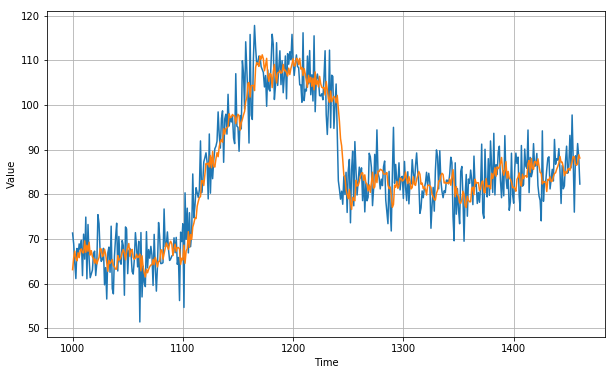

In [12]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model1.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
#print(np.array(forecast).shape)
results1 = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results1)
plt.show()

* Mean squre error and mean absolute error of the linear regression model

In [20]:
print("Linear regrassion MSE = ", keras.metrics.mean_squared_error(x_valid, results1).numpy())
print("Linear regrassion MAE = ", keras.metrics.mean_absolute_error(x_valid, results1).numpy())

Linear regrassion MSE =  32.222347
Linear regrassion MAE =  4.4890485


## Deep Neural Network

* Here we try to train a DNN model.
* Automatic tuning of learning rate with callbacks is used.

In [18]:
# Two layer DNN
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Optimizer with initial learning rate
optimizer1 = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model2.compile(loss="mse", optimizer=optimizer1)

In [19]:
# Construct learning rate scheduler based on the number of epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Training with callbacks
history2 = model2.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=2)

Epoch 1/100
31/31 - 0s - loss: 1209.8028
Epoch 2/100
31/31 - 0s - loss: 643.0093
Epoch 3/100
31/31 - 0s - loss: 284.1180
Epoch 4/100
31/31 - 0s - loss: 120.3576
Epoch 5/100
31/31 - 0s - loss: 61.8304
Epoch 6/100
31/31 - 0s - loss: 46.5161
Epoch 7/100
31/31 - 0s - loss: 43.7608
Epoch 8/100
31/31 - 0s - loss: 43.3895
Epoch 9/100
31/31 - 0s - loss: 43.3027
Epoch 10/100
31/31 - 0s - loss: 43.2416
Epoch 11/100
31/31 - 0s - loss: 43.1779
Epoch 12/100
31/31 - 0s - loss: 43.1152
Epoch 13/100
31/31 - 0s - loss: 43.0543
Epoch 14/100
31/31 - 0s - loss: 42.9881
Epoch 15/100
31/31 - 0s - loss: 42.9147
Epoch 16/100
31/31 - 0s - loss: 42.8413
Epoch 17/100
31/31 - 0s - loss: 42.7654
Epoch 18/100
31/31 - 0s - loss: 42.6822
Epoch 19/100
31/31 - 0s - loss: 42.5891
Epoch 20/100
31/31 - 0s - loss: 42.4886
Epoch 21/100
31/31 - 0s - loss: 42.3838
Epoch 22/100
31/31 - 0s - loss: 42.2766
Epoch 23/100
31/31 - 0s - loss: 42.1571
Epoch 24/100
31/31 - 0s - loss: 42.0370
Epoch 25/100
31/31 - 0s - loss: 41.9183
Epoc

* Plot the loss as a function of learning rate (lr is a function of the number of epoch)
* As it can be seen, the loss increases rapidly as the learning rate becomees too large. Learning rate < $10^{-5}$ should be used

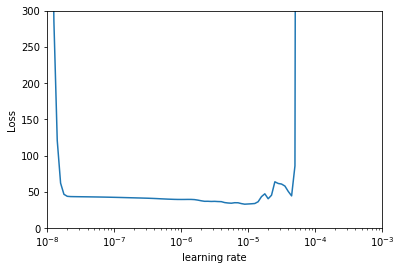

In [21]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history2.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.show()

* Traing the model with appropriate learning rage.

In [31]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

# Learning rate
optimizer2 = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model3.compile(loss="mse", optimizer=optimizer2)
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Training
history3 = model3.fit(dataset, epochs=200, verbose=2)

Epoch 1/200
31/31 - 0s - loss: 87.7493
Epoch 2/200
31/31 - 0s - loss: 43.6028
Epoch 3/200
31/31 - 0s - loss: 38.7608
Epoch 4/200
31/31 - 0s - loss: 37.7282
Epoch 5/200
31/31 - 0s - loss: 37.1056
Epoch 6/200
31/31 - 0s - loss: 36.4366
Epoch 7/200
31/31 - 0s - loss: 35.8752
Epoch 8/200
31/31 - 0s - loss: 35.2728
Epoch 9/200
31/31 - 0s - loss: 34.8312
Epoch 10/200
31/31 - 0s - loss: 34.3585
Epoch 11/200
31/31 - 0s - loss: 34.0734
Epoch 12/200
31/31 - 0s - loss: 33.6512
Epoch 13/200
31/31 - 0s - loss: 33.4335
Epoch 14/200
31/31 - 0s - loss: 33.2397
Epoch 15/200
31/31 - 0s - loss: 32.9861
Epoch 16/200
31/31 - 0s - loss: 32.8047
Epoch 17/200
31/31 - 0s - loss: 32.6935
Epoch 18/200
31/31 - 0s - loss: 32.5587
Epoch 19/200
31/31 - 1s - loss: 32.4357
Epoch 20/200
31/31 - 0s - loss: 32.3442
Epoch 21/200
31/31 - 0s - loss: 32.2617
Epoch 22/200
31/31 - 0s - loss: 32.1879
Epoch 23/200
31/31 - 0s - loss: 32.1293
Epoch 24/200
31/31 - 0s - loss: 32.0800
Epoch 25/200
31/31 - 1s - loss: 32.0580
Epoch 26/

* Plotting the training history
* As it can be seen, with appropriate learning rate, DNN can converge much faster than simple linear regression model, even if DNN has much more fitting parameters (331 vs 21).

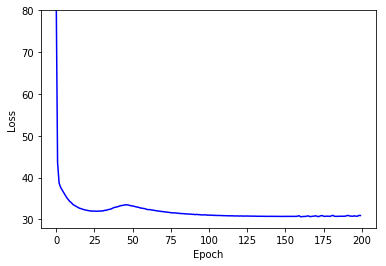

In [33]:
loss1 = history3.history['loss']
epochs1 = range(len(loss1))
plt.plot(epochs1, loss1, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([28,80])
plt.show()

* Prediction with DNN on validation set

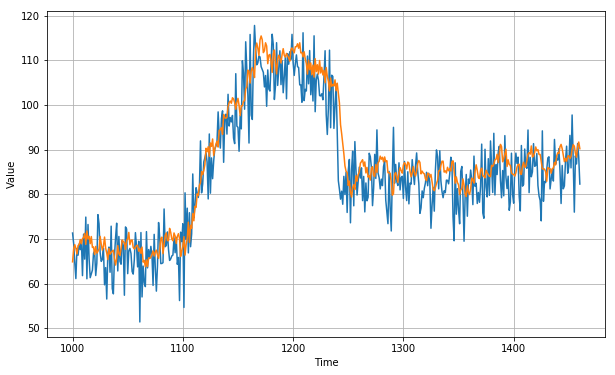

In [34]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model3.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results2 = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results2)
plt.show()

* However, the MSE and MAE of DNN is higher than that of linear regression model, indicating the overfitting during the training, and early stopping should be used.
* It also implies that complex model is not necessarily better than simple models.

In [35]:
print("MSE = ", keras.metrics.mean_squared_error(x_valid, results2).numpy())
print("MAE = ", keras.metrics.mean_absolute_error(x_valid, results2).numpy())

MSE =  38.7263
MAE =  5.0157976
